### Loading Libraries and Data

In [3]:
!pip install -U missingpy

     |████████████████████████████████| 51kB 2.1MB/s 


In [2]:
!pip install -U imblearn

Requirement already up-to-date: imblearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [56]:
%tensorflow_version 2.x
from numpy.random import seed
seed(2)
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from missingpy import MissForest
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization

print(tf.__version__)

2.3.0


In [5]:
from google.colab import files
uploaded= files.upload()
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Hep_c = pd.read_csv("hcvdat0.csv")

Hep_c = Hep_c.reindex(
    np.random.permutation(Hep_c.index))
Hep_c.drop(columns='Unnamed: 0',axis=1,inplace=True)
Hep_c

Saving hcvdat0.csv to hcvdat0.csv


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
469,0=Blood Donor,52,f,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2
592,3=Cirrhosis,47,m,42.0,nan,159.0,102.0,11.0,6.3,5.5,58.0,201.0,79.0
265,0=Blood Donor,58,m,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1
84,0=Blood Donor,39,m,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2
109,0=Blood Donor,42,m,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,0s=suspect Blood Donor,48,m,24.9,116.9,49.2,24.3,4.9,3.4,5.2,29.0,83.0,47.8
584,2=Fibrosis,75,f,36.0,nan,114.0,125.0,14.0,6.7,nan,57.0,177.0,72.0
493,0=Blood Donor,56,f,34.7,90.3,22.7,21.6,3.5,8.1,5.5,67.0,9.0,69.4
527,0=Blood Donor,63,f,27.8,85.7,25.4,38.9,4.2,6.1,4.0,63.0,46.0,56.9


In [6]:
Hep_c.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.0,614.0,597.0,614.0,615.0,615.0,615.0,605.0,615.0,615.0,614.0
mean,47.4,41.6,68.3,28.5,34.8,11.4,8.2,5.4,81.3,39.5,72.0
std,10.1,5.8,26.0,25.5,33.1,19.7,2.2,1.1,49.8,54.7,5.4
min,19.0,14.9,11.3,0.9,10.6,0.8,1.4,1.4,8.0,4.5,44.8
25%,39.0,38.8,52.5,16.4,21.6,5.3,6.9,4.6,67.0,15.7,69.3
50%,47.0,42.0,66.2,23.0,25.9,7.3,8.3,5.3,77.0,23.3,72.2
75%,54.0,45.2,80.1,33.1,32.9,11.2,9.6,6.1,88.0,40.2,75.4
max,77.0,82.2,416.6,325.3,324.0,254.0,16.4,9.7,1079.1,650.9,90.0


### Preprocessing Data

In [7]:
def data_processsing(Hepititis_c):

  Ohe=OneHotEncoder(sparse=False)
  Hep_c_new=pd.DataFrame(Ohe.fit_transform(Hepititis_c[['Sex','Category']]))
  Hep_c_new.rename(columns={0:'f',1:'m',2:'Blood Donor',3:'suspect Blood Donor',4:'Hepatitis',5:'Fibrosis',6:'Cirrhosis'},inplace=True)
  Hep_c_new = Hep_c_new.reindex(
      np.random.permutation(Hep_c_new.index))

  Hep_c_targets=Hep_c_new.iloc[:,2:]
  Hep_c_targets

  Hep_c_gender=Hep_c_new.iloc[:,:2]
  Hep_c_gender

  Hep_c_feat=Hepititis_c.drop(columns=['Category','Sex'],axis=1)

  Hep_c_feat=Hep_c_feat.join(Hep_c_gender)
  Hep_c_feat

  return Hep_c_feat,Hep_c_targets




In [8]:
# Target variable
df_feat,df_targets=data_processsing(Hep_c)
df_targets

,Blood Donor,suspect Blood Donor,Hepatitis,Fibrosis,Cirrhosis
396,1.0,0.0,0.0,0.0,0.0
550,0.0,0.0,0.0,0.0,1.0
320,1.0,0.0,0.0,0.0,0.0
181,1.0,0.0,0.0,0.0,0.0
112,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
36,1.0,0.0,0.0,0.0,0.0
42,1.0,0.0,0.0,0.0,0.0
216,1.0,0.0,0.0,0.0,0.0
394,1.0,0.0,0.0,0.0,0.0


In [10]:
# looking for num value in target
df_targets.isnull().sum()

Blood Donor            0
suspect Blood Donor    0
Hepatitis              0
Fibrosis               0
Cirrhosis              0
dtype: int64

In [11]:
# looking for null values in the features
pd.options.display.max_rows = 30
df_feat.isnull().sum()

Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
f        0
m        0
dtype: int64

In [13]:
# imputing the missing values
imputer=MissForest(n_jobs=-1,random_state=1)
df_features=pd.DataFrame(imputer.fit_transform(df_feat),index=df_feat.index,columns=df_feat.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [14]:
df_features.isnull().sum()

Age     0
ALB     0
ALP     0
ALT     0
AST     0
BIL     0
CHE     0
CHOL    0
CREA    0
GGT     0
PROT    0
f       0
m       0
dtype: int64

In [35]:
# package for over sampling as data is imbalanced 

from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

In [36]:
# over sampling as the data is imbalanced
smote=SMOTETomek(random_state=42)
x_over,y_over=smote.fit_sample(df_features.values,df_targets.values)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [37]:
df_feat_over=pd.DataFrame(data=x_over,columns=df_feat.columns)
df_feat_over

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,f,m
0,52.0,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2,1.0,0.0
1,47.0,42.0,57.2,159.0,102.0,11.0,6.3,5.5,58.0,201.0,79.0,0.0,1.0
2,58.0,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1,0.0,1.0
3,39.0,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2,0.0,1.0
4,42.0,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,40.1,43.1,56.0,14.7,21.0,8.1,7.5,5.4,75.1,18.0,78.6,0.6,0.4
2655,47.5,36.8,73.2,27.1,23.3,5.3,8.7,5.7,64.5,23.4,70.0,0.0,1.0
2656,45.1,39.6,118.8,24.9,24.0,10.2,8.6,6.3,60.1,19.6,70.9,0.3,0.7
2657,50.1,39.5,115.7,25.3,22.7,11.7,8.5,7.1,53.9,18.0,70.7,0.0,1.0


In [38]:
# Correcting data in the gender columns 
for values in df_feat_over['f']:
  if values<1:
    if values<0.5:
      df_feat_over['f'].replace(to_replace=values,value=0,inplace=True)
    else:
      df_feat_over['f'].replace(to_replace=values,value=1,inplace=True)
df_feat_over['f']

0      1.0
1      0.0
2      0.0
3      0.0
4      0.0
        ..
2654   1.0
2655   0.0
2656   0.0
2657   0.0
2658   1.0
Name: f, Length: 2659, dtype: float64

In [39]:
for val1 in df_feat_over['m']:
  if val1<1:
    
    if val1<0.5:
      df_feat_over['m'].replace(to_replace=val1,value=0,inplace=True)
    else:
      df_feat_over['m'].replace(to_replace=val1,value=1,inplace=True)
df_feat_over['m']

0      0.0
1      1.0
2      1.0
3      1.0
4      1.0
        ..
2654   0.0
2655   1.0
2656   1.0
2657   1.0
2658   0.0
Name: m, Length: 2659, dtype: float64

In [40]:
df_feat_over

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,f,m
0,52.0,51.5,81.8,26.3,20.6,7.8,6.7,5.9,88.0,16.3,82.2,1.0,0.0
1,47.0,42.0,57.2,159.0,102.0,11.0,6.3,5.5,58.0,201.0,79.0,0.0,1.0
2,58.0,41.3,58.9,12.8,23.4,5.4,8.2,5.7,60.0,10.8,70.1,0.0,1.0
3,39.0,43.9,90.1,87.9,60.6,8.6,9.9,4.6,98.0,99.3,66.2,0.0,1.0
4,42.0,44.1,46.8,23.8,19.4,7.0,10.8,6.3,95.0,19.7,73.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,40.1,43.1,56.0,14.7,21.0,8.1,7.5,5.4,75.1,18.0,78.6,1.0,0.0
2655,47.5,36.8,73.2,27.1,23.3,5.3,8.7,5.7,64.5,23.4,70.0,0.0,1.0
2656,45.1,39.6,118.8,24.9,24.0,10.2,8.6,6.3,60.1,19.6,70.9,0.0,1.0
2657,50.1,39.5,115.7,25.3,22.7,11.7,8.5,7.1,53.9,18.0,70.7,0.0,1.0


In [41]:
df_target_over=pd.DataFrame(data=y_over,columns=df_targets.columns)
df_target_over

,Blood Donor,suspect Blood Donor,Hepatitis,Fibrosis,Cirrhosis
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2654,0,0,0,0,1
2655,0,0,0,0,1
2656,0,0,0,0,1
2657,0,0,0,0,1


In [42]:
# splitting the data 
train_x,valid_x,train_y,valid_y=train_test_split(df_feat_over,df_target_over,test_size=0.4,random_state=1)
print('train x shape :', train_x.shape)
print('train y shape :', train_y.shape)
print('valid x shape :', valid_x.shape)
print('valid y shape :', valid_y.shape)

train x shape : (1595, 13)
train y shape : (1595, 5)
valid x shape : (1064, 13)
valid y shape : (1064, 5)


In [112]:
# standardizing the data
scaler = StandardScaler().fit(train_x.values)
scaledf = scaler.transform(train_x.values)
train_x = pd.DataFrame(scaledf, index=train_x.index, columns=train_x.columns)


scaler2 = StandardScaler().fit(valid_x.values)
vscaled = scaler2.transform(valid_x.values)
valid_x = pd.DataFrame(vscaled, index=valid_x.index, columns=valid_x.columns)


In [43]:
print('Training sample summary')
display.display(train_x.describe())
print('Valid sample summary')
display.display(valid_x.describe())

Training sample summary


,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,f,m
count,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0,1595.0
mean,50.0,41.2,71.1,29.1,34.5,11.1,8.0,5.5,83.6,45.6,72.0,0.4,0.6
std,9.4,5.1,19.9,24.9,31.3,13.2,1.7,0.9,37.9,47.7,4.6,0.5,0.5
min,23.0,14.9,11.3,0.9,10.6,0.8,1.4,1.4,9.0,4.5,44.8,0.0,0.0
25%,43.0,38.7,58.9,18.4,22.8,5.9,7.1,4.8,69.9,18.2,69.9,0.0,0.0
50%,50.1,41.4,69.2,25.2,27.2,8.0,8.1,5.5,78.0,27.6,72.1,0.0,1.0
75%,56.4,44.0,81.3,32.4,32.1,12.2,9.1,6.1,90.8,57.5,74.7,1.0,1.0
max,77.0,77.6,208.2,325.3,324.0,254.0,15.4,9.7,1079.1,491.0,90.0,1.0,1.0


Valid sample summary


,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,f,m
count,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0,1064.0
mean,50.1,41.5,70.6,28.8,32.7,10.8,8.0,5.5,83.2,46.1,71.9,0.4,0.6
std,9.2,6.0,22.4,22.4,24.0,10.5,1.7,0.9,34.4,47.4,4.6,0.5,0.5
min,19.0,19.3,15.4,1.2,12.0,2.0,1.7,2.4,8.0,7.0,47.8,0.0,0.0
25%,43.0,38.6,58.9,18.7,22.8,6.0,7.1,4.8,69.9,18.4,69.9,0.0,0.0
50%,50.3,41.6,68.9,25.2,27.1,8.2,8.1,5.5,77.4,28.6,72.0,0.0,1.0
75%,56.9,44.4,80.6,32.3,32.1,12.5,9.1,6.1,90.3,58.8,74.8,1.0,1.0
max,76.0,82.2,416.6,324.8,296.3,200.0,16.4,9.0,519.0,650.9,86.0,1.0,1.0


In [45]:
print('Training target sample summary')
display.display(train_y.describe())
print('Validation target sample summary')
display.display(valid_y.describe())

Training target sample summary


,Blood Donor,suspect Blood Donor,Hepatitis,Fibrosis,Cirrhosis
count,1595.0,1595.0,1595.0,1595.0,1595.0
mean,0.2,0.2,0.2,0.2,0.2
std,0.4,0.4,0.4,0.4,0.4
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0


Validation target sample summary


,Blood Donor,suspect Blood Donor,Hepatitis,Fibrosis,Cirrhosis
count,1064.0,1064.0,1064.0,1064.0,1064.0
mean,0.2,0.2,0.2,0.2,0.2
std,0.4,0.4,0.4,0.4,0.4
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0


### Build Model

In [64]:
baseline_model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(train_x.shape[1],)),
    keras.layers.Dense(32,activation=tf.nn.relu,),
    keras.layers.Dense(16,activation=tf.nn.relu,),
    keras.layers.Dense(5,activation=tf.nn.softmax)

  ])




baseline_model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
baseline_model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                448       
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 85        
Total params: 2,117
Trainable params: 2,117
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [65]:
EPOCHS = 200
model1 = baseline_model.fit(train_x, train_y, epochs=EPOCHS,
                    validation_data= (valid_x, valid_y), verbose=1)
                    # callbacks=[PrintDot(), tensorboard_callback])


Epoch 1/200
50/50 [==============================] - 0s 5ms/step - loss: 2.6936 - accuracy: 0.2564 - val_loss: 1.6143 - val_accuracy: 0.3459
Epoch 2/200
50/50 [==============================] - 0s 2ms/step - loss: 1.5353 - accuracy: 0.3586 - val_loss: 1.4291 - val_accuracy: 0.3759
Epoch 3/200
50/50 [==============================] - 0s 2ms/step - loss: 1.3825 - accuracy: 0.4401 - val_loss: 1.3510 - val_accuracy: 0.4267
Epoch 4/200
50/50 [==============================] - 0s 2ms/step - loss: 1.3091 - accuracy: 0.4577 - val_loss: 1.2827 - val_accuracy: 0.4831
Epoch 5/200
50/50 [==============================] - 0s 2ms/step - loss: 1.2608 - accuracy: 0.4734 - val_loss: 1.2574 - val_accuracy: 0.4812
Epoch 6/200
50/50 [==============================] - 0s 2ms/step - loss: 1.2072 - accuracy: 0.5022 - val_loss: 1.2517 - val_accuracy: 0.4962
Epoch 7/200
50/50 [==============================] - 0s 2ms/step - loss: 1.1711 - accuracy: 0.5292 - val_loss: 1.1756 - val_accuracy: 0.5423
Epoch 8/200
5

### Plot Results

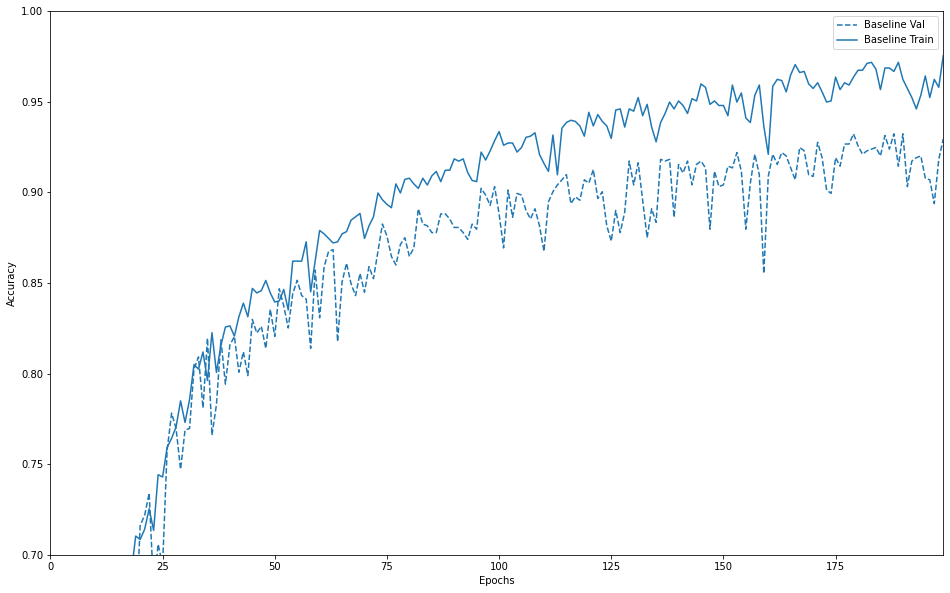

In [66]:
import matplotlib.pyplot as plt


def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0.7,1])

plot_history([('baseline', model1)])

### Explaination